# THE SIMILARITY OF ECB's COMMUNICATION

The purpose of this Notebook is to implement the paper 'The Similarity of ECB’s Communication' by Diego Amaya and Jean-Yves Filbien.

### Librairies

In [1]:
!pip install nltk


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import jaccard
from collections import Counter
import statsmodels.api as sm
from wordcloud import WordCloud

from tabulate import tabulate
import string
import re
import yfinance as yf

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import bigrams
from nltk.stem import PorterStemmer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33649\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33649\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### BCE Data Communications

In [4]:
df_bce = pd.read_csv("export_ecb_pc.csv", sep= ",")

In [5]:
df_bce

,date,text
0,2006-12-07,Introductory statement with Q A Jean...
1,2006-11-02,Introductory statement with Q A Jean...
2,2006-10-05,Introductory statement with Q A Jean...
3,2006-08-31,Introductory statement with Q A Jean...
4,2006-08-03,Introductory statement with Q A Jean...
...,...,...
172,2020-06-04,INTRODUCTORY STATEMENTPRESS CONFERENCEChristin...
173,2020-07-16,INTRODUCTORY STATEMENTPRESS CONFERENCEChristin...
174,2020-09-10,"Christine Lagarde, President of the ECB,Luis..."
175,2020-10-29,"Christine Lagarde, President of the ECB,Luis..."


In [6]:
df_bce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    177 non-null    object
 1   text    177 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB


In [7]:
is_sorted = df_bce['date'].is_monotonic_increasing
print(f"The dates are sorted ? {is_sorted}")

The dates are sorted ? False


In [8]:
df_bce = df_bce.sort_values('date')

print(df_bce.head())
print(df_bce.tail())

           date                                               text
145  2004-01-08         Introductory statement to the press con...
144  2004-02-05         Introductory statement to the press con...
143  2004-03-04         Introductory statement to the press con...
142  2004-04-01         Introductory statement to the press con...
141  2004-05-06         Introductory statement to the press con...
           date                                               text
172  2020-06-04  INTRODUCTORY STATEMENTPRESS CONFERENCEChristin...
173  2020-07-16  INTRODUCTORY STATEMENTPRESS CONFERENCEChristin...
174  2020-09-10    Christine Lagarde, President of the ECB,Luis...
175  2020-10-29    Christine Lagarde, President of the ECB,Luis...
176  2020-12-10    Christine Lagarde, President of the ECB,Luis...


In [9]:
df_bce.set_index('date', inplace = True)

### Text processing

In [10]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


def processing_text(words:str):
    tokens = words.split() #we tokenize
    res = [ps.stem(word.lower()) for word in tokens if not word.lower() in stop_words] #On enleve les stop_words + stem
    return ' '.join(res)

In [11]:
df_bce["processed_text"] = df_bce['text'].apply(processing_text)

### Statistics

In [12]:
class TextAnalyzer:
    def __init__(self, text):
        self.text = text
        self.sentences = sent_tokenize(text)
        self.words = word_tokenize(text)
        self.unique_words = set(self.words)
        # self.stopwords = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)
        self.hashtags = set(re.findall(r'#\w+', text))
        self.mentions = set(re.findall(r'@\w+', text))
    
    def num_characters(self):
        return len(self.text)
    
    def num_words(self):
        return len(self.words)
    
    def num_capital_characters(self):
        return sum(1 for c in self.text if c.isupper())
    
    def num_capital_words(self):
        return sum(1 for w in self.words if w.isupper())
    
    def num_punctuations(self):
        return sum(1 for c in self.text if c in self.punctuations)
    
    def num_words_in_quotes(self):
        return sum(1 for w in self.words if w[0] in ['\'', '"'])
    
    def num_sentences(self):
        return len(self.sentences)
    
    def num_unique_words(self):
        return len(self.unique_words)
    
    def num_hashtags(self):
        return len(self.hashtags)
    
    def num_mentions(self):
        return len(self.mentions)
    
    def unique_words_vs_word_count(self):
        return len(self.unique_words) / len(self.words)
    
    def stopwords_count_vs_word_count(self):
        return self.num_stopwords() / len(self.words)

In [13]:
nb_words = dict()
nb_capital_caracters = dict()
n_unique_words = dict()
n_sentences = dict()
documents = df_bce['processed_text'].to_list()
n_word = 0
n_c_character = 0
n_sentence = 0
n_unique_word = 0
for document in notebook.tqdm(documents):
    n_word += TextAnalyzer(document).num_words()
    n_sentence += TextAnalyzer(document).num_sentences()
    n_unique_word += TextAnalyzer(document).num_unique_words()
    n_c_character += TextAnalyzer(document).num_characters()

  0%|          | 0/177 [00:00<?, ?it/s]

In [84]:
tuples_list = []
unique_labels = ["results"]
for label in unique_labels:
    tuples_list.append((label, n_c_character, n_word, n_unique_word, n_sentence))

print(tabulate(tuples_list, headers=['nb_capital_characters', 'nb_word', 'n_unique_word', 'n_sentence'], tablefmt="fancy_grid"))

╒═════════╤═════════════════════════╤═══════════╤═════════════════╤══════════════╕
│         │   nb_capital_characters │   nb_word │   n_unique_word │   n_sentence │
╞═════════╪═════════════════════════╪═══════════╪═════════════════╪══════════════╡
│ results │                 4139121 │    714597 │          202958 │        50474 │
╘═════════╧═════════════════════════╧═══════════╧═════════════════╧══════════════╛


In [15]:
df_bce.index = pd.to_datetime(df_bce.index)

Text(0, 0.5, 'Nb of Chars')

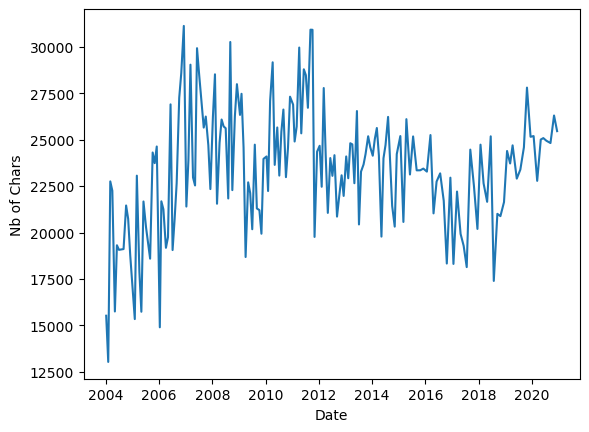

In [16]:
plt.plot(df_bce['processed_text'].str.len(), label='nb of chars')
# Add axis labels
plt.xlabel('Date')
plt.ylabel('Nb of Chars')

<AxesSubplot:>

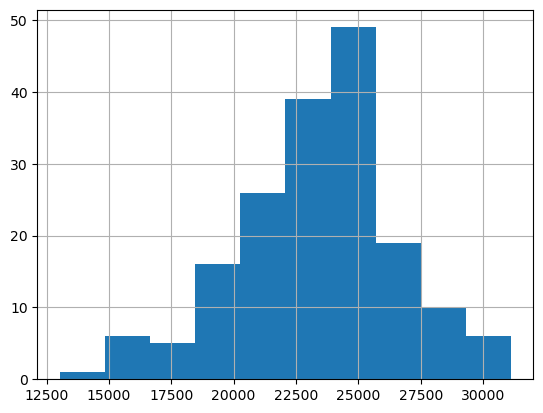

In [17]:
len_char = df_bce['processed_text'].str.len().copy()
len_char.hist()

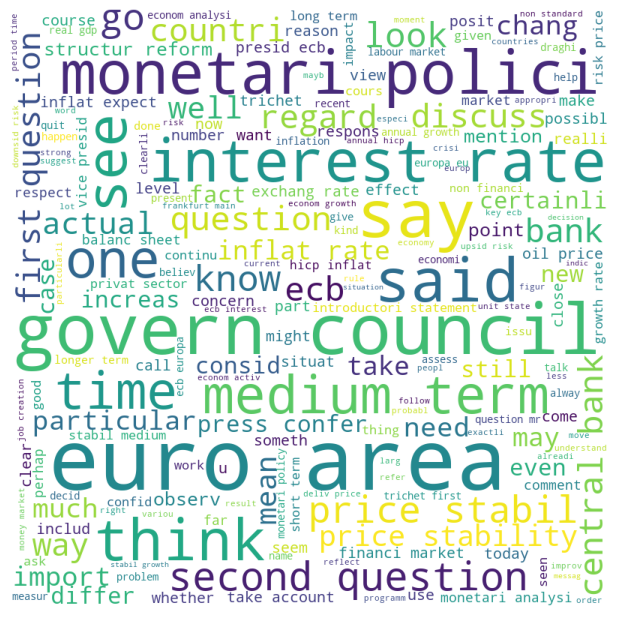

In [18]:
text_combined = ' '.join(df_bce['processed_text'].astype(str))


wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      min_font_size=10).generate(text_combined)
                       
plt.figure(figsize=(6, 6), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
  
plt.show()

### SImilarities

In [19]:
def generate_bigrams(text):
    tokens = nltk.word_tokenize(text)
    return set(ngrams(tokens, 2))

def calculate_jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    similarity = len(intersection) / len(union) if union else 0
    return similarity

In [20]:
df_bce["bigrams"] = df_bce['processed_text'].apply(generate_bigrams)

#### Safety check

In [21]:
calculate_jaccard_similarity(df_bce.iloc[0]['bigrams'],
                                             df_bce.iloc[0]['bigrams'])

1.0

#### Calculating Similarities

In [22]:
similarities = []
similarities.append(None)
for i in range(len(df_bce) - 1):
    similarities.append(calculate_jaccard_similarity(df_bce.iloc[i]['bigrams'],
                                                 df_bce.iloc[i + 1]['bigrams']))

df_bce['similarity'] = similarities

In [23]:
# df_bce.set_index('date', inplace=True)
# df_bce.index = pd.to_datetime(df_bce.index)

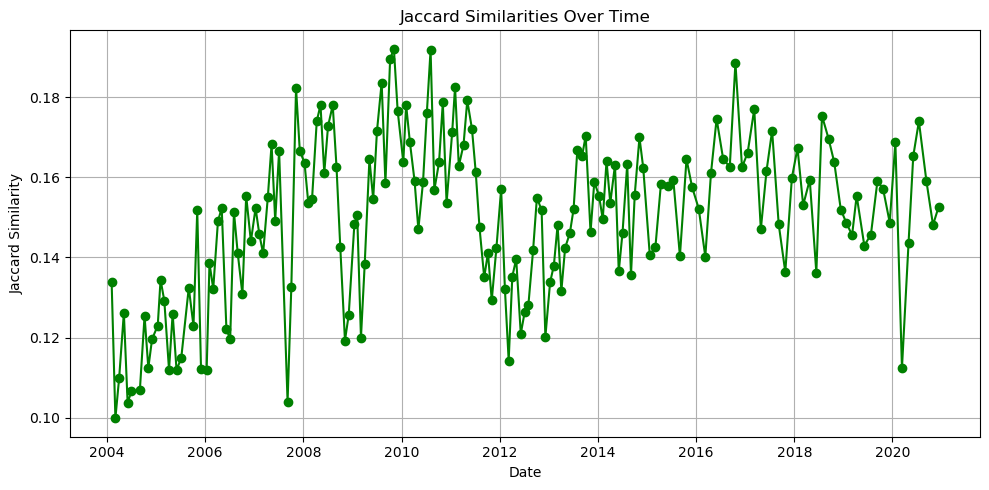

In [24]:
plt.figure(figsize=(10, 5))  
plt.plot(df_bce.index, df_bce['similarity'], marker='o', linestyle='-', color='green')  

plt.title('Jaccard Similarities Over Time')  
plt.xlabel('Date')  
plt.ylabel('Jaccard Similarity')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

### Pessimism

In [25]:
df_sentiment = pd.read_csv("Loughran-McDonald_MasterDictionary_1993-2021.csv", sep = ",")

In [26]:
df_sentiment

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [27]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86531 entries, 0 to 86530
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Word                86530 non-null  object 
 1   Seq_num             86531 non-null  int64  
 2   Word Count          86531 non-null  int64  
 3   Word Proportion     86531 non-null  float64
 4   Average Proportion  86531 non-null  float64
 5   Std Dev             86531 non-null  float64
 6   Doc Count           86531 non-null  int64  
 7   Negative            86531 non-null  int64  
 8   Positive            86531 non-null  int64  
 9   Uncertainty         86531 non-null  int64  
 10  Litigious           86531 non-null  int64  
 11  Strong_Modal        86531 non-null  int64  
 12  Weak_Modal          86531 non-null  int64  
 13  Constraining        86531 non-null  int64  
 14  Syllables           86531 non-null  int64  
 15  Source              86531 non-null  object 
dtypes: f

In [28]:
positives = df_sentiment["Word"][df_sentiment["Positive"] > 0]
negatives = df_sentiment["Word"][df_sentiment["Negative"] > 0]

we select positives and negatives words

In [29]:
positive_terms = [ps.stem(positive_term.lower()) for positive_term in positives]
positive_terms = list(dict.fromkeys(positive_terms)) #on enleve les duplicatas

In [30]:
positive_terms

['abl',
 'abund',
 'acclaim',
 'accomplish',
 'achiev',
 'adequ',
 'advanc',
 'advantag',
 'allianc',
 'assur',
 'attain',
 'attract',
 'beauti',
 'benefici',
 'benefit',
 'best',
 'better',
 'bolster',
 'boom',
 'boost',
 'breakthrough',
 'brilliant',
 'charit',
 'collabor',
 'compliment',
 'complimentari',
 'conclus',
 'conduc',
 'confid',
 'construct',
 'courteou',
 'creativ',
 'delight',
 'depend',
 'desir',
 'despit',
 'destin',
 'dilig',
 'distinct',
 'dream',
 'easier',
 'easili',
 'easi',
 'effici',
 'empow',
 'enabl',
 'encourag',
 'enhanc',
 'enjoy',
 'enthusiasm',
 'enthusiast',
 'excel',
 'except',
 'excit',
 'exclus',
 'exemplari',
 'fantast',
 'favor',
 'favorit',
 'friendli',
 'gain',
 'good',
 'greatest',
 'greatli',
 'great',
 'happiest',
 'happili',
 'happi',
 'highest',
 'honor',
 'ideal',
 'impress',
 'improv',
 'incred',
 'influenti',
 'inform',
 'ingenu',
 'innov',
 'insight',
 'inspir',
 'integr',
 'invent',
 'inventor',
 'leadership',
 'lead',
 'loyal',
 'lucr',

In [31]:
negative_terms = [ps.stem(negative_term.lower()) for negative_term in negatives]
negative_terms = list(dict.fromkeys(negative_terms)) #removing duplicates

In [32]:
negative_terms

['abandon',
 'abdic',
 'aberr',
 'abet',
 'abnorm',
 'abolish',
 'abrog',
 'abrupt',
 'abruptli',
 'absenc',
 'absente',
 'abus',
 'accid',
 'accident',
 'accus',
 'acquiesc',
 'acquit',
 'acquitt',
 'adulter',
 'adversari',
 'advers',
 'aftermath',
 'against',
 'aggrav',
 'alert',
 'alien',
 'alleg',
 'allegedli',
 'annoy',
 'annul',
 'anomali',
 'anomal',
 'anticompetit',
 'antitrust',
 'argu',
 'argument',
 'arrearag',
 'arrear',
 'arrest',
 'artifici',
 'assault',
 'assert',
 'attrit',
 'avers',
 'backdat',
 'bad',
 'bail',
 'bailout',
 'balk',
 'bankrupt',
 'bankruptci',
 'ban',
 'bar',
 'barrier',
 'bottleneck',
 'boycott',
 'boycot',
 'breach',
 'break',
 'breakag',
 'breakdown',
 'bribe',
 'briberi',
 'burden',
 'burdensom',
 'burn',
 'calam',
 'calamit',
 'cancel',
 'careless',
 'carelessli',
 'catastroph',
 'caution',
 'cautionari',
 'ceas',
 'censur',
 'challeng',
 'chargeoff',
 'circumv',
 'circumvent',
 'claim',
 'clawback',
 'closeout',
 'close',
 'closur',
 'coerc',
 'co

In [33]:
def calculate_pessimism(text:str, positive_words = positive_terms, negative_words = negative_terms):
    tokens = word_tokenize(text)
    total_words = len(tokens)
    
 
    word_counts = Counter(tokens)
    positive_count = sum(word_counts[word] for word in positive_words)
    negative_count = sum(word_counts[word] for word in negative_words)
    
    pessimism_score = (negative_count - positive_count) / total_words
    return pessimism_score

In [34]:
#Test

calculate_pessimism(df_bce['processed_text'][0],
                    positive_terms,
                    negative_terms)

0.01268183513614323

In [35]:
df_bce['pessimism'] = df_bce["processed_text"].apply(calculate_pessimism)

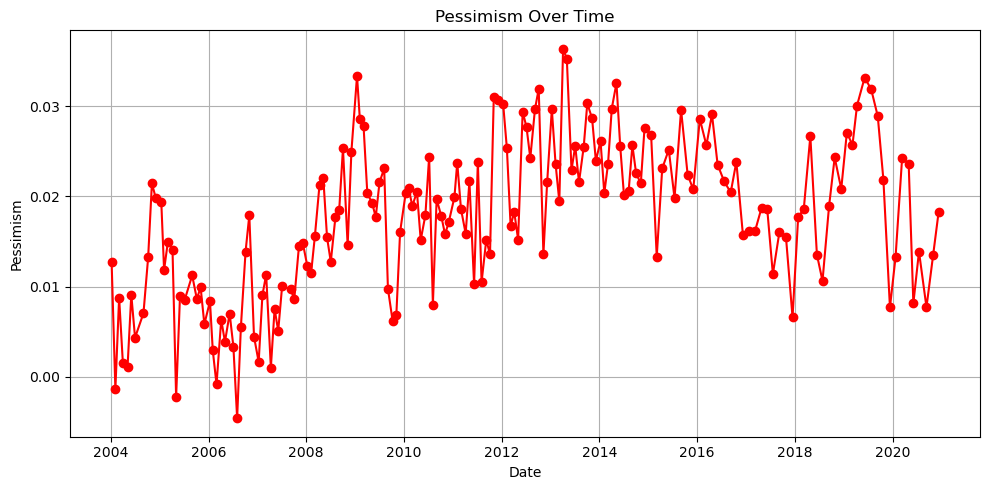

In [36]:
plt.figure(figsize=(10, 5))  
plt.plot(df_bce.index, df_bce['pessimism'], marker='o', linestyle='-', color='red')  

plt.title('Pessimism Over Time')  
plt.xlabel('Date')  
plt.ylabel('Pessimism')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

### Market Data

#### 1.STOXX

In [37]:
ticker_symbol = "^STOXX"

ticker_data = yf.Ticker(ticker_symbol)

start_date = '2004-01-01'
end_date = '2023-01-01'

In [38]:
# Get historical data for the defined time period
historical_data = ticker_data.history(period='1d', start=start_date, end=end_date)

In [39]:
df_market = pd.DataFrame(data = {'STOXX600' : historical_data["Close"]}, index = historical_data.index)

In [40]:
df_market

,STOXX600
Date,
2004-04-26 00:00:00+02:00,247.070007
2004-04-27 00:00:00+02:00,246.919998
2004-04-28 00:00:00+02:00,243.380005
2004-04-29 00:00:00+02:00,241.250000
2004-04-30 00:00:00+02:00,239.050003
...,...
2022-12-23 00:00:00+01:00,427.450012
2022-12-27 00:00:00+01:00,428.000000
2022-12-28 00:00:00+01:00,427.459991


In [41]:
df_market['log_returns'] = np.log(df_market['STOXX600'] / df_market['STOXX600'].shift(1))
df_market['expected_return'] = df_market['log_returns'].rolling(window=200).mean()
df_market['abnormal_returns'] = df_market["log_returns"] - df_market['expected_return']

df_market['cumulative_ar'] = df_market['abnormal_returns'].rolling(window=11, min_periods=1, center=True).sum()

In [42]:
df_market

,STOXX600,log_returns,expected_return,abnormal_returns,cumulative_ar
Date,,,,,
2004-04-26 00:00:00+02:00,247.070007,NaN,NaN,NaN,NaN
2004-04-27 00:00:00+02:00,246.919998,-0.000607,NaN,NaN,NaN
2004-04-28 00:00:00+02:00,243.380005,-0.014440,NaN,NaN,NaN
2004-04-29 00:00:00+02:00,241.250000,-0.008790,NaN,NaN,NaN
2004-04-30 00:00:00+02:00,239.050003,-0.009161,NaN,NaN,NaN
...,...,...,...,...,...
2022-12-23 00:00:00+01:00,427.450012,0.000445,-0.000043,0.000488,-0.011233
2022-12-27 00:00:00+01:00,428.000000,0.001286,-0.000097,0.001382,0.000901
2022-12-28 00:00:00+01:00,427.459991,-0.001262,-0.000089,-0.001174,-0.001653


In [43]:
df_market = df_market.dropna(axis = 0)

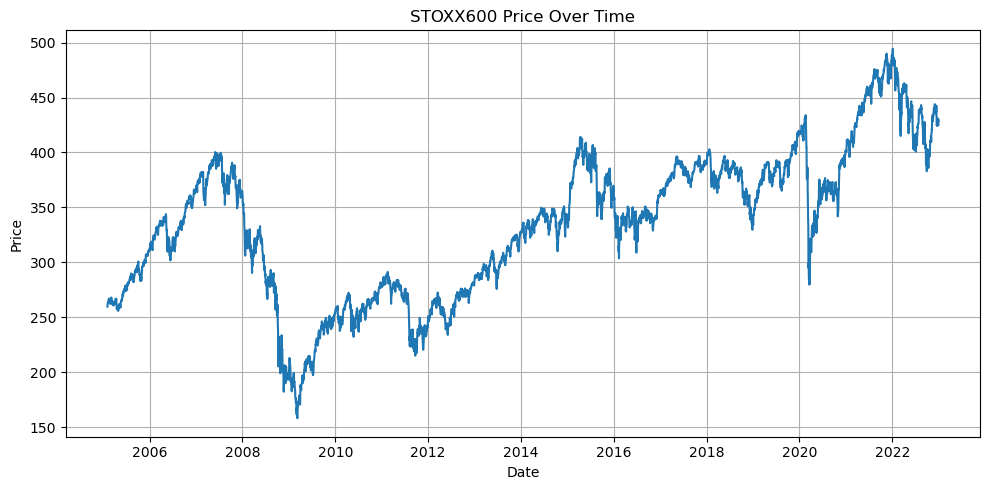

In [44]:
plt.figure(figsize=(10, 5))  
plt.plot(df_market.index, df_market['STOXX600'])  

plt.title('STOXX600 Price Over Time')  
plt.xlabel('Date')  
plt.ylabel('Price')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

In [45]:
df_forecast_gdp = pd.read_csv("real_forecast_gdp.csv")

#### 2. GDP

In [46]:
df_real_gdp = pd.read_csv("GDP.csv")
df_real_gdp

,DATE,TIME PERIOD,Gross domestic product at market prices (MNA.A.N.B6.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N)
0,1995-12-31,1995,6337710.41
1,1996-12-31,1996,6636498.93
2,1997-12-31,1997,6819195.68
3,1998-12-31,1998,7110871.80
4,1999-12-31,1999,7430926.97
5,2000-12-31,2000,7869362.68
6,2001-12-31,2001,8241897.76
7,2002-12-31,2002,8538773.27
8,2003-12-31,2003,8767565.20
9,2004-12-31,2004,9167938.81


In [47]:
df_real_gdp.set_index('DATE', inplace=True)

In [48]:
df_real_gdp["pct_gdp"] = df_real_gdp["Gross domestic product at market prices (MNA.A.N.B6.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.V.N)"].pct_change()

In [49]:
df_real_gdp["pct_gdp"]

DATE
1995-12-31         NaN
1996-12-31    0.047145
1997-12-31    0.027529
1998-12-31    0.042773
1999-12-31    0.045009
2000-12-31    0.059001
2001-12-31    0.047340
2002-12-31    0.036020
2003-12-31    0.026794
2004-12-31    0.045665
2005-12-31    0.042859
2006-12-31    0.057698
2007-12-31    0.061949
2008-12-31    0.032272
2009-12-31   -0.044900
2010-12-31    0.037098
2011-12-31    0.031685
2012-12-31    0.005970
2013-12-31    0.010529
2014-12-31    0.023135
2015-12-31    0.036766
2016-12-31    0.027223
2017-12-31    0.042027
2018-12-31    0.035077
2019-12-31    0.035860
2020-12-31   -0.039133
2021-12-31    0.086782
2022-12-31    0.086551
Name: pct_gdp, dtype: float64

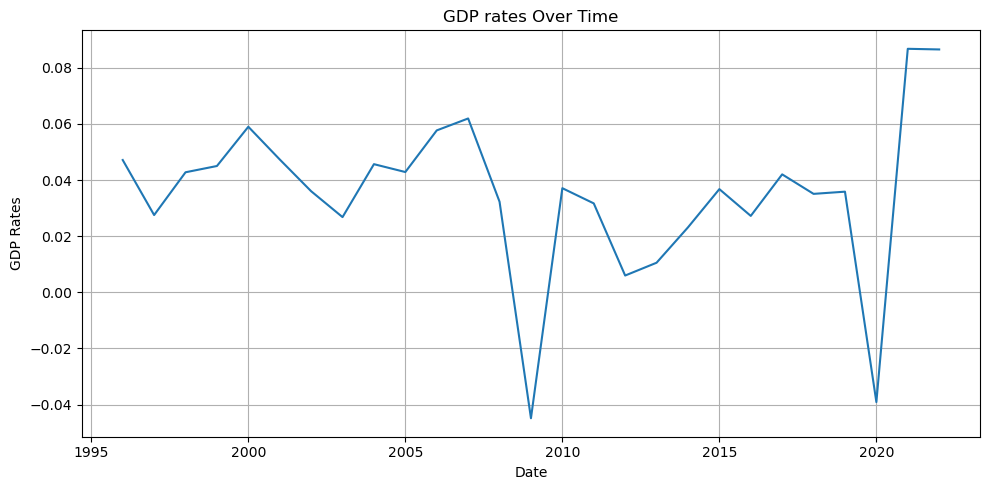

In [50]:
plt.figure(figsize=(10, 5))  
plt.plot(df_real_gdp['TIME PERIOD'], df_real_gdp['pct_gdp'])  

plt.title('GDP rates Over Time')  
plt.xlabel('Date')  
plt.ylabel('GDP Rates')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

#### 3. MRO

In [51]:
df_mro = pd.read_csv("MRO.csv")
df_mro

,DATE,TIME PERIOD,Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)
0,1999-01-01,01 Jan 1999,3.0
1,1999-01-02,02 Jan 1999,3.0
2,1999-01-03,03 Jan 1999,3.0
3,1999-01-04,04 Jan 1999,3.0
4,1999-01-05,05 Jan 1999,3.0
...,...,...,...
9123,2023-12-24,24 Dec 2023,4.5
9124,2023-12-25,25 Dec 2023,4.5
9125,2023-12-26,26 Dec 2023,4.5
9126,2023-12-27,27 Dec 2023,4.5


In [52]:
df_mro["change_mro"] = df_mro["Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)"].diff()

on fait une differenciation parce que ce sont des pourcentages....

In [53]:
df_mro.set_index('TIME PERIOD', inplace=True)
df_mro.index = pd.to_datetime(df_mro.index)

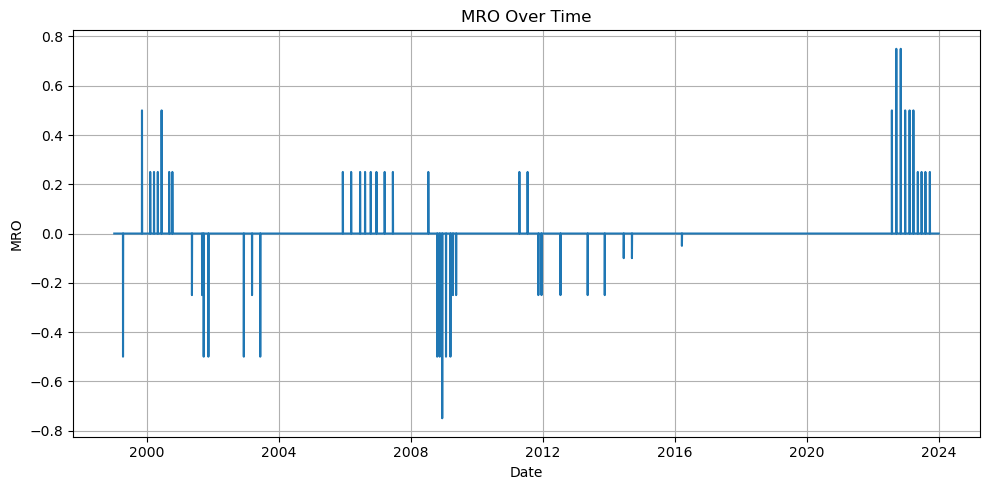

In [54]:
plt.figure(figsize=(10, 5))  
plt.plot(df_mro['change_mro'])  

plt.title('MRO Over Time')  
plt.xlabel('Date')  
plt.ylabel('MRO')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

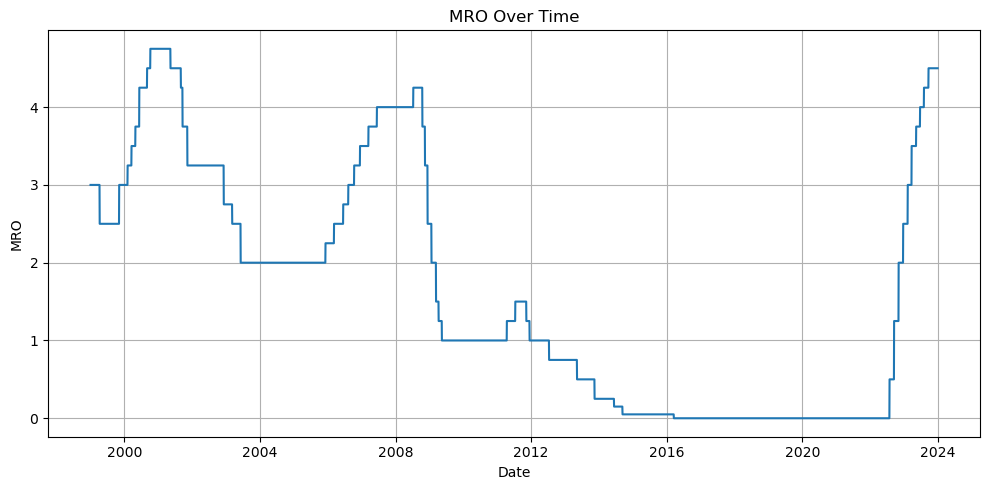

In [55]:
plt.figure(figsize=(10, 5))  
plt.plot(df_mro['Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)'])  

plt.title('MRO Over Time')  
plt.xlabel('Date')  
plt.ylabel('MRO')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

#### 4. Inflation

In [56]:
df_inflation = pd.read_csv("inflation.csv")
df_inflation

,DATE,TIME PERIOD,HICP - Overall index (ICP.M.U2.N.000000.4.ANR)
0,1997-01-31,1997Jan,2.0
1,1997-02-28,1997Feb,1.8
2,1997-03-31,1997Mar,1.6
3,1997-04-30,1997Apr,1.3
4,1997-05-31,1997May,1.4
...,...,...,...
318,2023-07-31,2023Jul,5.3
319,2023-08-31,2023Aug,5.2
320,2023-09-30,2023Sep,4.3
321,2023-10-31,2023Oct,2.9


In [57]:
df_inflation.set_index('DATE', inplace = True)
df_inflation.index.name = "date"

df_inflation.index = pd.to_datetime(df_inflation.index)

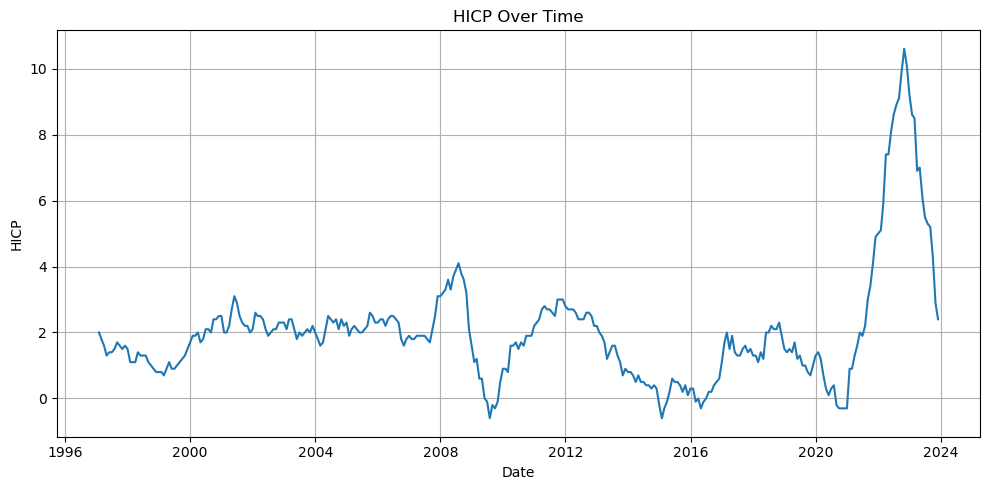

In [58]:
plt.figure(figsize=(10, 5))  
plt.plot(df_inflation["HICP - Overall index (ICP.M.U2.N.000000.4.ANR)"])

plt.title('HICP Over Time')  
plt.xlabel('Date')  
plt.ylabel('HICP')  
plt.grid(True)  
plt.tight_layout()  


plt.show()

### Regression

In [59]:
df_bce.columns

Index(['text', 'processed_text', 'bigrams', 'similarity', 'pessimism'], dtype='object')

In [60]:
df1 = df_bce[['similarity', 'pessimism']]

In [61]:
df_market.columns

Index(['STOXX600', 'log_returns', 'expected_return', 'abnormal_returns',
       'cumulative_ar'],
      dtype='object')

In [62]:
df_market.index.name = 'date'

In [63]:
df2 = df_market[["cumulative_ar", "abnormal_returns"]]

In [64]:
df1.index = df1.index.strftime('%Y-%m-%d')
df2.index = df2.index.strftime('%Y-%m-%d')

In [65]:
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)

merged_df = pd.merge_asof(df1, df2, left_index=True, right_index=True, direction='backward')

In [66]:
merged_df

,similarity,pessimism,cumulative_ar,abnormal_returns
date,,,,
2004-01-08,NaN,0.012682,NaN,NaN
2004-02-05,0.133903,-0.001374,NaN,NaN
2004-03-04,0.099846,0.008781,NaN,NaN
2004-04-01,0.109923,0.001549,NaN,NaN
2004-05-06,0.126144,0.001114,NaN,NaN
...,...,...,...,...
2020-06-04,0.165281,0.008145,0.013049,-0.007265
2020-07-16,0.173980,0.013886,0.021944,-0.004461
2020-09-10,0.159052,0.007720,0.005241,-0.005416


In [67]:
df3 = df_mro[['change_mro',
              "Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)"]]
df3.index = pd.to_datetime(df3.index)

In [68]:
df4 = df_real_gdp[["pct_gdp"]]
df4.index = pd.to_datetime(df4.index)

In [69]:
merged_all = pd.merge_asof(merged_df, df4, left_index=True, right_index=True, direction='backward')

In [70]:
merged_all

,similarity,pessimism,cumulative_ar,abnormal_returns,pct_gdp
date,,,,,
2004-01-08,NaN,0.012682,NaN,NaN,0.026794
2004-02-05,0.133903,-0.001374,NaN,NaN,0.026794
2004-03-04,0.099846,0.008781,NaN,NaN,0.026794
2004-04-01,0.109923,0.001549,NaN,NaN,0.026794
2004-05-06,0.126144,0.001114,NaN,NaN,0.026794
...,...,...,...,...,...
2020-06-04,0.165281,0.008145,0.013049,-0.007265,0.035860
2020-07-16,0.173980,0.013886,0.021944,-0.004461,0.035860
2020-09-10,0.159052,0.007720,0.005241,-0.005416,0.035860


In [71]:
merged = pd.merge_asof(merged_all, df3, left_index=True, right_index=True, direction='forward')

In [72]:
df5 = df_inflation[["HICP - Overall index (ICP.M.U2.N.000000.4.ANR)"]]
df5.index = pd.to_datetime(df5.index)

In [73]:
merged = pd.merge_asof(merged, df5, left_index=True, right_index=True, direction='backward')

In [74]:
merged

,similarity,pessimism,cumulative_ar,abnormal_returns,pct_gdp,change_mro,Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV),HICP - Overall index (ICP.M.U2.N.000000.4.ANR)
date,,,,,,,,
2004-01-08,NaN,0.012682,NaN,NaN,0.026794,0.0,2.0,2.0
2004-02-05,0.133903,-0.001374,NaN,NaN,0.026794,0.0,2.0,1.8
2004-03-04,0.099846,0.008781,NaN,NaN,0.026794,0.0,2.0,1.6
2004-04-01,0.109923,0.001549,NaN,NaN,0.026794,0.0,2.0,1.7
2004-05-06,0.126144,0.001114,NaN,NaN,0.026794,0.0,2.0,2.1
...,...,...,...,...,...,...,...,...
2020-06-04,0.165281,0.008145,0.013049,-0.007265,0.035860,0.0,0.0,0.1
2020-07-16,0.173980,0.013886,0.021944,-0.004461,0.035860,0.0,0.0,0.3
2020-09-10,0.159052,0.007720,0.005241,-0.005416,0.035860,0.0,0.0,-0.2


In [75]:
merged = merged.dropna(axis = 0)

### Regressions

All the insights are in the report

In [76]:
reference_date = merged.index.min()
merged['day'] = np.log((merged.index - reference_date).days + 1)

C:\Users\33649\AppData\Local\Temp\ipykernel_38832\3345447119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['day'] = np.log((merged.index - reference_date).days + 1)


In [77]:
merged = merged.dropna(axis = 0)

In [78]:
merged["log_similarity"] = merged["similarity"].apply(np.log)

In [79]:
merged["abs_car"] = abs(merged["cumulative_ar"])
merged[" log_similarity * pessimism"] = merged["pessimism"] * merged["log_similarity"]

In [80]:
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
similarity,165.0,0.151874,0.018378,0.103977,0.140543,0.153559,0.164073,0.192085
pessimism,165.0,0.018298,0.008335,-0.004581,0.012746,0.018763,0.024272,0.036351
cumulative_ar,165.0,-0.001310,0.041547,-0.284841,-0.015791,0.005418,0.020683,0.078763
abnormal_returns,165.0,-0.001264,0.015683,-0.120702,-0.005808,-0.000583,0.005238,0.050618
pct_gdp,165.0,0.029222,0.025539,-0.044900,0.023135,0.035077,0.042859,0.061949
change_mro,165.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV),165.0,1.244545,1.337419,0.000000,0.050000,1.000000,2.000000,4.250000
HICP - Overall index (ICP.M.U2.N.000000.4.ANR),165.0,1.581818,1.040771,-0.600000,0.700000,1.700000,2.400000,4.100000
day,165.0,7.545451,1.121368,0.000000,7.177782,7.848934,8.272315,8.663888
log_similarity,165.0,-1.892319,0.125368,-2.263581,-1.962239,-1.873672,-1.807443,-1.649815


### $ logSimilarity_i=\alpha_0+\alpha_1 logTime_i+\beta^{\prime}Control_i+\epsilon_i$

In [81]:
Y = merged['log_similarity']
X = merged[['day', 'pct_gdp', 'HICP - Overall index (ICP.M.U2.N.000000.4.ANR)']]
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     9.564
Date:                Sun, 14 Jan 2024   Prob (F-statistic):           7.55e-06
Time:                        10:36:06   Log-Likelihood:                 122.53
No. Observations:                 165   AIC:                            -237.1
Df Residuals:                     161   BIC:                            -224.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### $\left|C A R_i\right|=\gamma_0+\gamma_1 \text { Pessimism }_i+\eta_i$

In [82]:
Y = merged['abs_car']
X = merged[["pessimism"]]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_car   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.847
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.176
Time:                        10:36:06   Log-Likelihood:                 337.38
No. Observations:                 165   AIC:                            -670.8
Df Residuals:                     163   BIC:                            -664.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.006      3.304      0.0

### $\left|C A R_i\right|=\gamma_0+\gamma_1 \operatorname{logSimilarity~}_i * \text { Pessimism }_i+\alpha^{\prime} \text { Control }_i+\eta_i$

In [83]:
Y = merged['abs_car']
X = merged[[" log_similarity * pessimism", 'HICP - Overall index (ICP.M.U2.N.000000.4.ANR)']]
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_car   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.114
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.124
Time:                        10:36:06   Log-Likelihood:                 338.58
No. Observations:                 165   AIC:                            -671.2
Df Residuals:                     162   BIC:                            -661.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------